Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_heads]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 36 seconds.



Posterior Summary:
          mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
p_heads  0.332  0.13    0.09    0.567      0.002    0.002    3053.0    4044.0   

         r_hat  
p_heads    1.0  


<Figure size 1000x600 with 0 Axes>

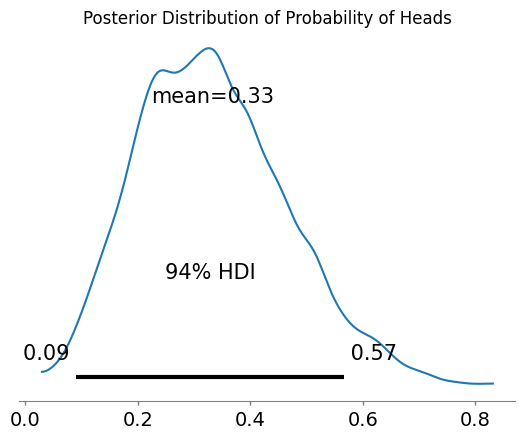

In [9]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Observed data (0 for tails, 1 for heads)
observed_data = [0, 0, 1, 1, 0, 0, 0, 0, 1, 0]

# Create the model
with pm.Model() as coin_model:
    # Prior for probability of heads 
    p_heads = pm.Beta(name="p_heads", alpha=1, beta=1)
    
    # Likelihood - Bernoulli distribution for coin flips
    y = pm.Bernoulli('y', p=p_heads, observed=observed_data)
    
    # Sample from posterior
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot posterior distribution
az.plot_posterior(trace, var_names=["p_heads"])
plt.title("Posterior Distribution of Probability of Heads")

# Calculate and print summary statistics
summary = az.summary(trace, var_names=["p_heads"])
print("\nPosterior Summary:")
print(summary)

plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_heads]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 41 seconds.



Posterior Summary:
          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
p_heads  0.409  0.102   0.213     0.59      0.002    0.001    3035.0   

         ess_tail  r_hat  
p_heads    4944.0    1.0  


<Figure size 1000x600 with 0 Axes>

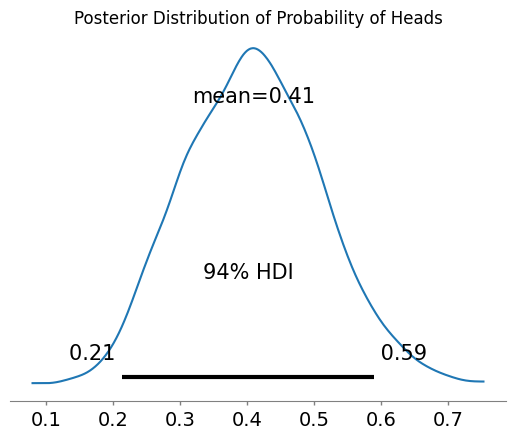

In [10]:
posterior_samples = trace.posterior['p_heads'].values.flatten()

# Method of moments estimation for alpha and beta parameters
mean = np.mean(posterior_samples)
var = np.var(posterior_samples)
alpha_post = mean * (mean * (1 - mean) / var - 1)
beta_post = (1 - mean) * (mean * (1 - mean) / var - 1)

observed_data_second = [1, 1, 0, 1, 0, 0, 1, 0, 0, 1]


# Second experiment using posterior from first as prior
with pm.Model() as second_model:
    # Use fitted parameters from first experiment as prior
    p_heads = pm.Beta(name="p_heads", alpha=alpha_post, beta=beta_post)
    y = pm.Bernoulli('y', p=p_heads, observed=observed_data_second)
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)
    
    
# Plot the results
plt.figure(figsize=(10, 6))

# Plot posterior distribution
az.plot_posterior(trace, var_names=["p_heads"])
plt.title("Posterior Distribution of Probability of Heads")

# Calculate and print summary statistics
summary = az.summary(trace, var_names=["p_heads"])
print("\nPosterior Summary:")
print(summary)

plt.show()

Cele doua distributii posterioare sunt diferite deoraece avem un numar diferit de aruncari care au rezultat in ban in al doilea experiment. Avand mai multe succese(aruncari rezultate in ban) in al doilea experiment, distributia a priori s-a modificat pentru a estima o probabilitate a banului mai mare.

In [19]:
from hmmlearn import hmm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Dimensiunea gridului
dimensiune_grid = (10, 10)

# Lista de culori predefinite
culori = [
    "red", "blue", "green", "yellow", 
    "purple", "orange", "pink", "cyan", 
    "brown", "lime"
]

# Citirea gridului
df = pd.read_csv('grid_culori.csv')
grid_culori = df.to_numpy

# Generarea secvenței de culori observate
observatii = ['red','red','lime','yellow','blue']

# Mapare culori -> indecși
culoare_to_idx = {culoare: idx for idx, culoare in enumerate(culori)}
idx_to_culoare = {idx: culoare for culoare, idx in culoare_to_idx.items()}

# Transformăm secvența de observații în indecși
observatii_idx = [culoare_to_idx[c] for c in observatii]

# Definim stările ascunse ca fiind toate pozițiile din grid (100 de stări)
numar_stari = dimensiune_grid[0] * dimensiune_grid[1]
stari_ascunse = [(i, j) for i in range(dimensiune_grid[0]) for j in range(dimensiune_grid[1])]
stare_to_idx = {stare: idx for idx, stare in enumerate(stari_ascunse)}
idx_to_stare = {idx: stare for stare, idx in stare_to_idx.items()}

# Matrice de tranziție
transitions = np.zeros((numar_stari, numar_stari))
for i, j in stari_ascunse:
    vecini = [
        (i - 1, j), (i + 1, j), (i, j - 1), (i, j + 1)  # sus, jos, stânga, dreapta
    ]
    vecini_valizi = [stare_to_idx[(x, y)] for x, y in vecini if 0 <= x < 10 and 0 <= y < 10]
    ######

# Matrice de emisie
emissions = np.zeros((numar_stari, len(culori)))
######
# Calculam probabilitățile de tranziție
for i, j in stari_ascunse:
    idx_curent = stare_to_idx[(i, j)]
    
    # Definim mișcarile posibile și probabilitatile lor
    miscari = []
    prob_miscari = []
    
    # Stanga (40% daca e posibil)
    if j > 0:
        miscari.append((i, j-1))
        prob_miscari.append(0.4)
    
    # Restul miscarilor (sus, jos, dreapta, sau ramae pe loc)
    # cu probabilitati egale pentru probabilitatea ramasa
    prob_ramasa = (1.0 - (0.4 if j > 0 else 0)) / 4
    
    # Sus
    if i > 0:
        miscari.append((i-1, j))
        prob_miscari.append(prob_ramasa)
    
    # Jos
    if i < dimensiune_grid[0]-1:
        miscari.append((i+1, j))
        prob_miscari.append(prob_ramasa)
    
    # Dreapta
    if j < dimensiune_grid[1]-1:
        miscari.append((i, j+1))
        prob_miscari.append(prob_ramasa)
    
    # Ramae pe loc
    miscari.append((i, j))
    prob_miscari.append(prob_ramasa)
    
    # Normalizam probabilitățile
    suma_prob = sum(prob_miscari)
    prob_miscari = [p/suma_prob for p in prob_miscari]
    
    # Populam matricea de tranziție
    for miscare, prob in zip(miscari, prob_miscari):
        idx_destinatie = stare_to_idx[miscare]
        transitions[idx_curent][idx_destinatie] = prob


# matricea de emisii
for i, j in stari_ascunse:
    idx_stare = stare_to_idx[(i, j)]
    culoare = grid_culori[i][j]
    idx_culoare = culoare_to_idx[culoare]
    emissions[idx_stare][idx_culoare] = 1.0

# Modelul HMM

model = hmm.MultinomialHMM(n_components=numar_stari)

model.startprob_ = np.ones(numar_stari) / numar_stari  # probabilitate uniforma initiala
model.transmat_ = transitions
model.emissionprob_ = emissions

######

# Rulăm algoritmul Viterbi pentru secvența de observații
######



# Convertim secvența de stări în poziții din grid
drum = [idx_to_stare[idx] for idx in secventa_stari]

# Vizualizăm drumul pe grid
fig, ax = plt.subplots(figsize=(8, 8))
for i in range(dimensiune_grid[0]):
    for j in range(dimensiune_grid[1]):
        culoare = grid_culori[i, j]
        ax.add_patch(plt.Rectangle((j, dimensiune_grid[0] - i - 1), 1, 1, color=culoare))
        ax.text(j + 0.5, dimensiune_grid[0] - i - 0.5, culoare, 
                color="white", ha="center", va="center", fontsize=8, fontweight="bold")

# Evidențiem drumul rezultat
for idx, (i, j) in enumerate(drum):
    ax.add_patch(plt.Circle((j + 0.5, dimensiune_grid[0] - i - 0.5), 0.3, color="black", alpha=0.7))
    ax.text(j + 0.5, dimensiune_grid[0] - i - 0.5, str(idx + 1), 
            color="white", ha="center", va="center", fontsize=10, fontweight="bold")

# Setări axă
ax.set_xlim(0, dimensiune_grid[1])
ax.set_ylim(0, dimensiune_grid[0])
ax.set_xticks(range(dimensiune_grid[1]))
ax.set_yticks(range(dimensiune_grid[0]))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(visible=True, color="black", linewidth=0.5)
ax.set_aspect("equal")
plt.title("Drumul rezultat al stărilor ascunse", fontsize=14)
plt.show()

IndexError: index 9 is out of bounds for axis 0 with size 9

Subiect 1 ex 2:
Daca eliminam posibilitatea agentului sa se miste la stanga:

Probabilitatile se schimba

Inainte: 40% stanga, 15% pentru fiecare din celelalte directii
DUpa: 25% pentru fiecare din cele 4 optiuni ramase (sus, jos, dreapta, stationare)


Efecte asupra comportamentului agentului:

Va tinde sa se miște mai mult spre dreapta (deoarece nu mai poate merge la stanga)
Drumul cel mai probabil va fi diferit fata de versiunea anterioara